# Predicting Heart Disease: DSCI 100 Group Project Report  (Group 23)

### Introduction:

Cardiovascular diseases (CVDs), or heart diseases, encompasses a range of medical conditions that affect the heart and blood vessels. Worldwide, CVDs are the leading cause of death with nearly 18 million deaths a year (World Health Organization, 2023). Early detection is key to treatment, prevention, and management of heart disease; our data analysis aims to help with this. 

The dataset used is from: https://archive.ics.uci.edu/dataset/45/heart+disease. The data was published in 1988 and the dataset we are using is the one specifically collected in Cleveland. The dataset consists of 303 observations and 14 variables.

The question we aim to address is: **can we predict if a patient has heart disease based on their age, resting blood pressure, serum cholesterol, and maximum resting heart rate?**

### Methods & Results:

First we load in the required libraries into this Jupyter notebook so that we can use it to edit, wrangle and visualize any data. We also import the `RColorBrewer` library so that we can make our plots color-blind friendly.

In [5]:
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
library(repr)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

We downloaded the dataset from Kaggle and uploaded it to a remote repistory (GitHub). This makes the dataset reproducible. The code below downloads the dataset from the remote repository into this notebook which is the local repository. Then we read the csv file that is downloaded.

In [6]:
#These lines of code bring the data into R and make it into a table showing the first 5 rows
download.file("https://raw.githubusercontent.com/Aamitoz-Sharma/Group_23_project/main/heart.csv", "heart_data.csv") #downloading file
heart_data <- read_csv("heart_data.csv")
head(heart_data)


Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


Next, we wrangle the dataset. First we use `select` to only obtain the coloumns that we are intereseted in i.e. the categorical variable we want to predict and the predictors. Then we use `mutate` to change the datatype of the variable that we want to predict (`HeartDisease`) into a categorical variable(fct) so that we can use it in the classification model that we want to use. We also change the numbers in `HeartDisease` from 0 and 1 to "yes" and "no" so that it is easier to understand.

In [7]:
#This set of data will select the data points we are interested in Age, Resting blood pressure, Cholesterol, Max heart rate and Heart Disease
heart <- heart_data |> 
    select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease) |>
#This line changes the Heart Disease variable from a continous quantitative variable(dbl) to a categorical variable(fct)
    mutate(HeartDisease = as_factor(HeartDisease)) |>
#This line changes the factor variables from 0 to no and 1 to yes
    mutate(HeartDisease = fct_recode(HeartDisease, "yes" = "1", "no" = "0")) 
head(heart)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
49,160,180,156,yes
37,130,283,98,no
48,138,214,108,yes
54,150,195,122,no
39,120,339,170,no


The following code splits the dataset into training and testing data as this allows us to know how good our model is and if it is making major mistakes while predicting.

In [8]:
heart_split <- initial_split(heart, prop = 0.75, strata = HeartDisease) #splitting into training and testing data.
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

head(heart_train)
head(heart_test)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
54,150,195,122,no
54,110,208,142,no
48,120,284,120,no
37,130,211,142,no
39,120,204,145,no
42,115,211,137,no


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
49,160,180,156,yes
37,130,283,98,no
48,138,214,108,yes
39,120,339,170,no
45,130,237,170,no


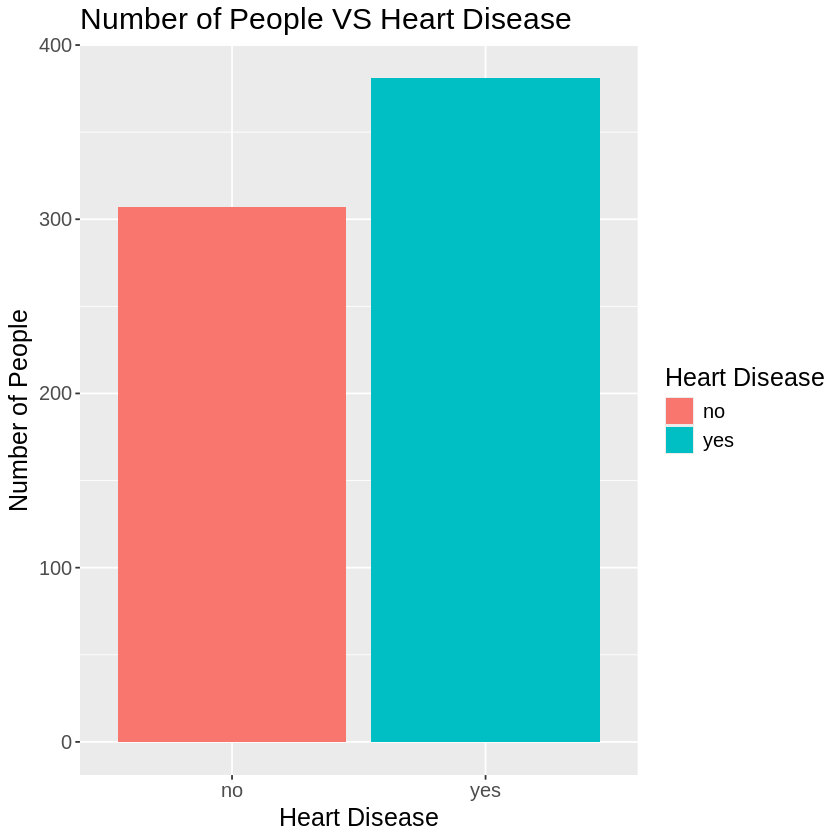

In [9]:
options(repr.plot.width = 7, repr.plot.height = 7) 
heart_disease_plot <- heart_train |>
    ggplot(aes(x = HeartDisease, fill = HeartDisease)) +
    geom_bar() +
    xlab("Heart Disease") +
    ylab("Number of People") +
    labs(fill = "Heart Disease") +
    ggtitle("Number of People VS Heart Disease") +
    theme(text = element_text(size = 15))

heart_disease_plot

In [10]:
set.seed(1) #setting seed to make the code reproducible
# Finding the best k for predicting heart disease using Age and Resting Blood pressure as predictors
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_recipe_Age_RestingBP <- recipe(HeartDisease ~ Age + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_RestingBP_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_RestingBP) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_RestingBP_best_k

[1] 46

In [11]:
set.seed(1)
# Finding the best k for predicting heart disease using Age and Cholesterol as predictors
heart_recipe_Age_Cholesterol <- recipe(HeartDisease ~ Age + Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_Cholesterol_best_k

[1] 41

In [12]:
set.seed(1)
# Finding the best k for predicting heart disease using Age and MaxHR as predictors
heart_recipe_Age_MaxHR <- recipe(HeartDisease ~ Age + MaxHR,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_MaxHR) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_MaxHR_best_k 

[1] 26

In [13]:
set.seed(1)
# Finding the best k for predicting heart disease using MaxHR and Cholesterol as predictors
heart_recipe_MaxHR_Cholesterol <- recipe(HeartDisease ~ MaxHR + Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

MaxHR_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_MaxHR_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
MaxHR_Cholesterol_best_k 

[1] 61

In [14]:
set.seed(1)
# Finding the best k for predicting heart disease using MaxHR and RestingBP
heart_recipe_RestingBP_MaxHR <- recipe(HeartDisease ~ MaxHR + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

RestingBP_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_RestingBP_MaxHR) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
RestingBP_MaxHR_best_k 

[1] 61

In [15]:
set.seed(1)
# Finding the best k for predicting heart disease using Cholesterol and RestingBP as predictors
heart_recipe_RestingBP_Cholesterol <- recipe(HeartDisease ~ Cholesterol + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

RestingBP_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_RestingBP_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
RestingBP_Cholesterol_best_k 

[1] 31

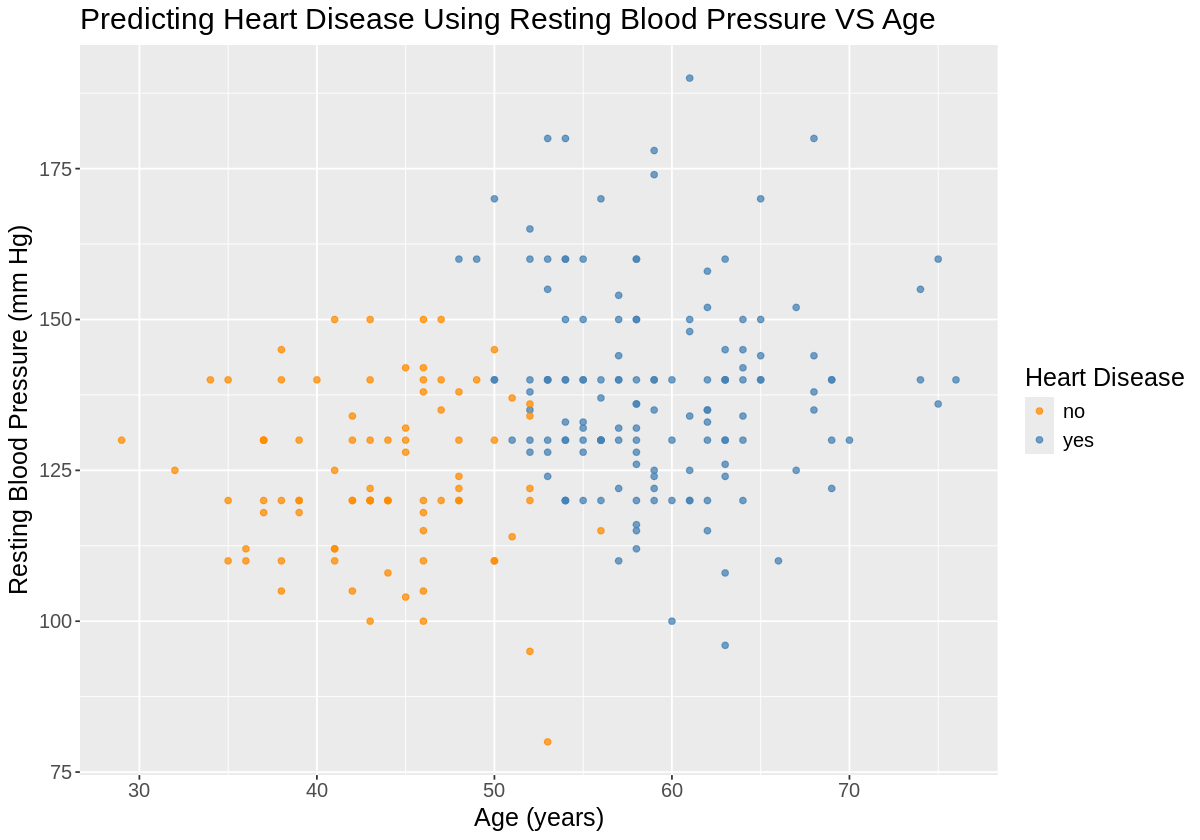

In [16]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_RestingBP <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_RestingBP_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_RestingBP <- workflow() |>
        add_recipe(heart_recipe_Age_RestingBP) |>
        add_model(heart_spec_Age_RestingBP) |>
        fit(data = heart_train)

Heart_preds_Age_RestingBP <- heart_fit_Age_RestingBP |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_RestingBP <- ggplot() +
  geom_point(data = Heart_preds_Age_RestingBP,
             mapping = aes(x = Age,
                           y = RestingBP,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Resting Blood Pressure (mm Hg)") +
  ggtitle("Predicting Heart Disease Using Resting Blood Pressure VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 15))

heart_plot_Age_RestingBP

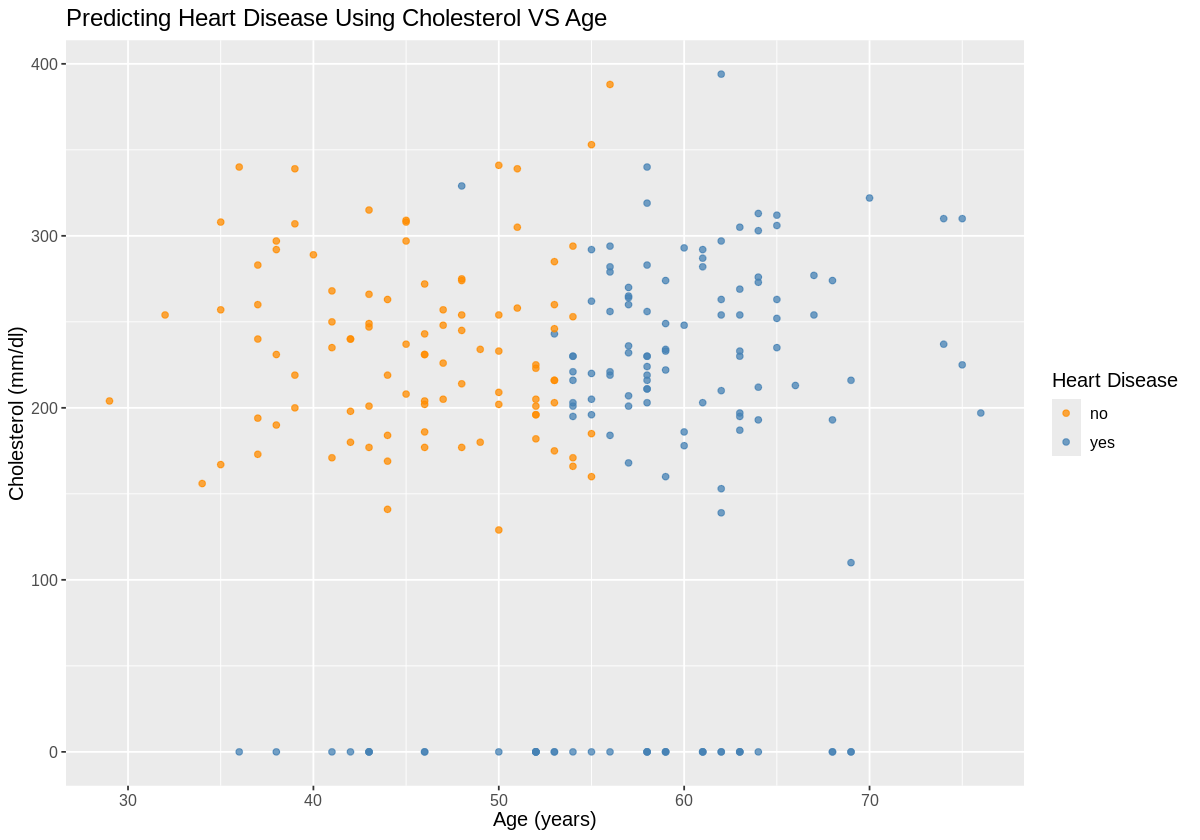

In [17]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_Cholesterol <- workflow() |>
        add_recipe(heart_recipe_Age_Cholesterol) |>
        add_model(heart_spec_Age_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_Age_Cholesterol <- heart_fit_Age_Cholesterol |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_Age_Cholesterol,
             mapping = aes(x = Age,
                           y = Cholesterol,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Predicting Heart Disease Using Cholesterol VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_Age_Cholesterol

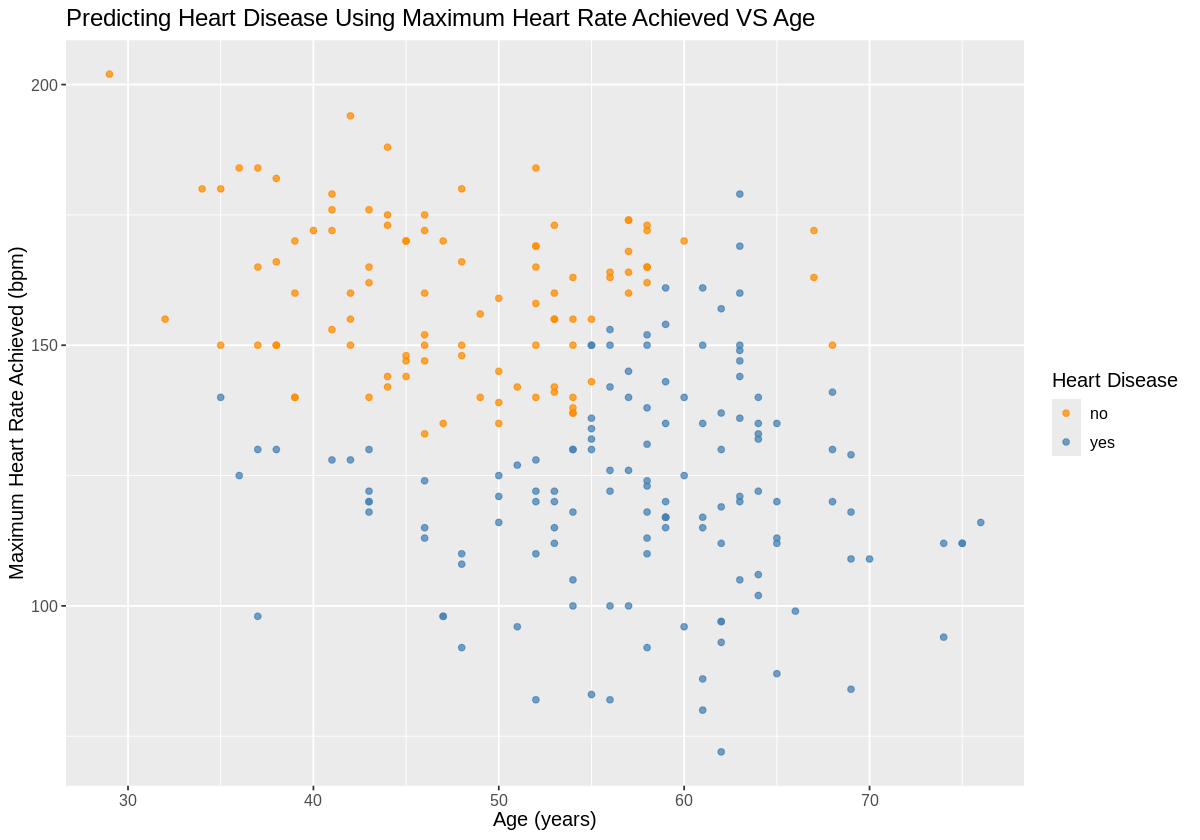

In [18]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_MaxHR <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_MaxHR <- workflow() |>
        add_recipe(heart_recipe_Age_MaxHR) |>
        add_model(heart_spec_Age_MaxHR) |>
        fit(data = heart_train)

Heart_preds_Age_MaxHR <- heart_fit_Age_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_MaxHR <- ggplot() +
  geom_point(data = Heart_preds_Age_MaxHR,
             mapping = aes(x = Age,
                           y = MaxHR,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Maximum Heart Rate Achieved (bpm)") +
  ggtitle("Predicting Heart Disease Using Maximum Heart Rate Achieved VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_Age_MaxHR

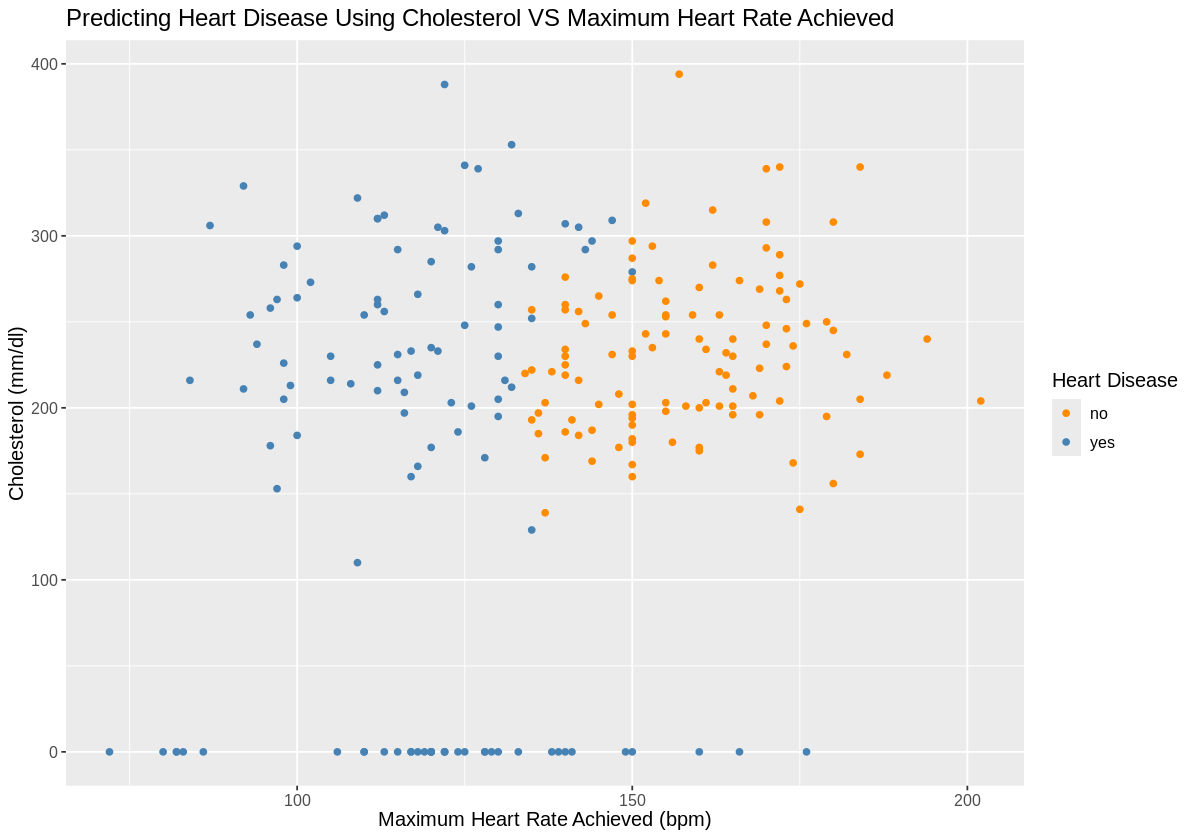

In [19]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_MaxHR_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = MaxHR_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_MaxHR <- workflow() |>
        add_recipe(heart_recipe_MaxHR_Cholesterol) |>
        add_model(heart_spec_MaxHR_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_MaxHR_Cholesterol <- heart_fit_Age_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_MaxHR_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_MaxHR_Cholesterol,
             mapping = aes(x = MaxHR,
                           y = Cholesterol,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Maximum Heart Rate Achieved (bpm)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Predicting Heart Disease Using Cholesterol VS Maximum Heart Rate Achieved") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_MaxHR_Cholesterol

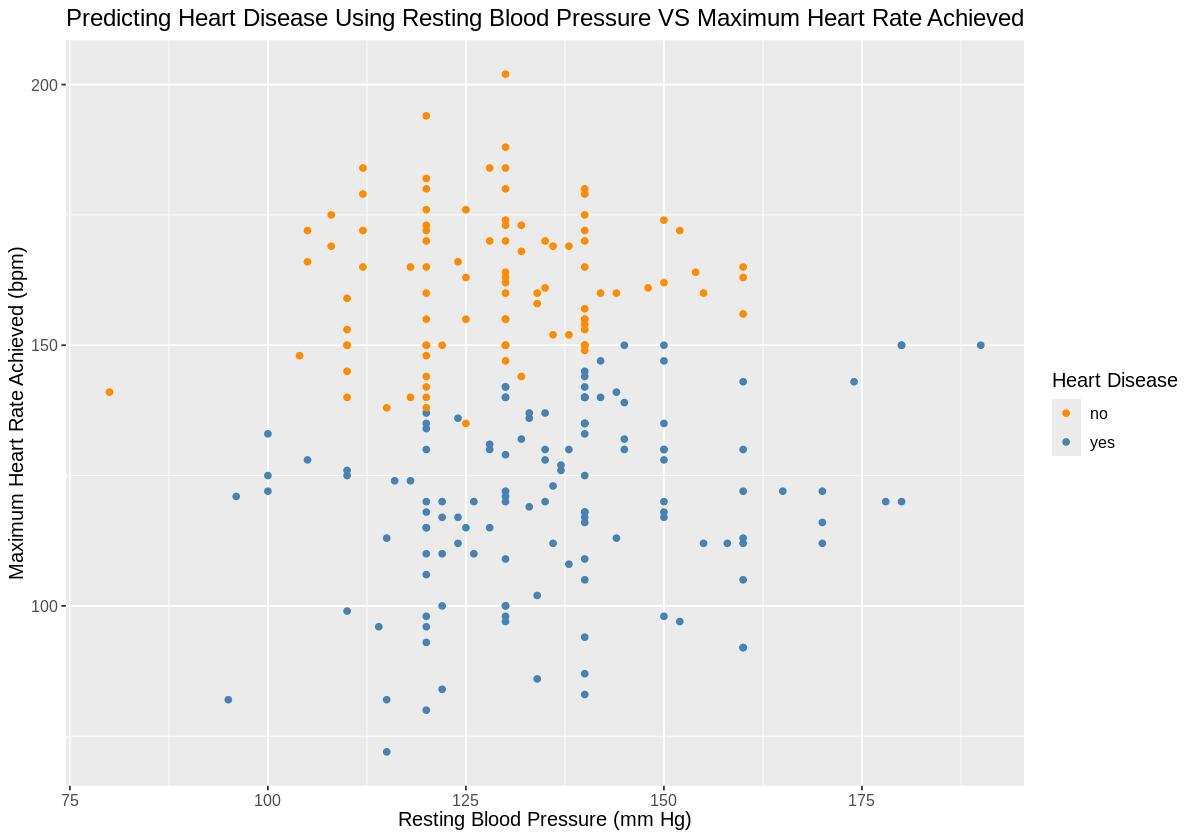

In [20]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_RestingBP_MaxHR <- nearest_neighbor(weight_func = "rectangular", neighbors = RestingBP_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_RestingBP_MaxHR <- workflow() |>
        add_recipe(heart_recipe_RestingBP_MaxHR) |>
        add_model(heart_spec_RestingBP_MaxHR) |>
        fit(data = heart_train)

Heart_preds_RestingBP_MaxHR <- heart_fit_RestingBP_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_RestingBP_MaxHR <- ggplot() +
  geom_point(data = Heart_preds_RestingBP_MaxHR,
             mapping = aes(x = RestingBP,
                           y = MaxHR,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Resting Blood Pressure (mm Hg)",
       y = "Maximum Heart Rate Achieved (bpm)") +
  ggtitle("Predicting Heart Disease Using Resting Blood Pressure VS Maximum Heart Rate Achieved") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_RestingBP_MaxHR

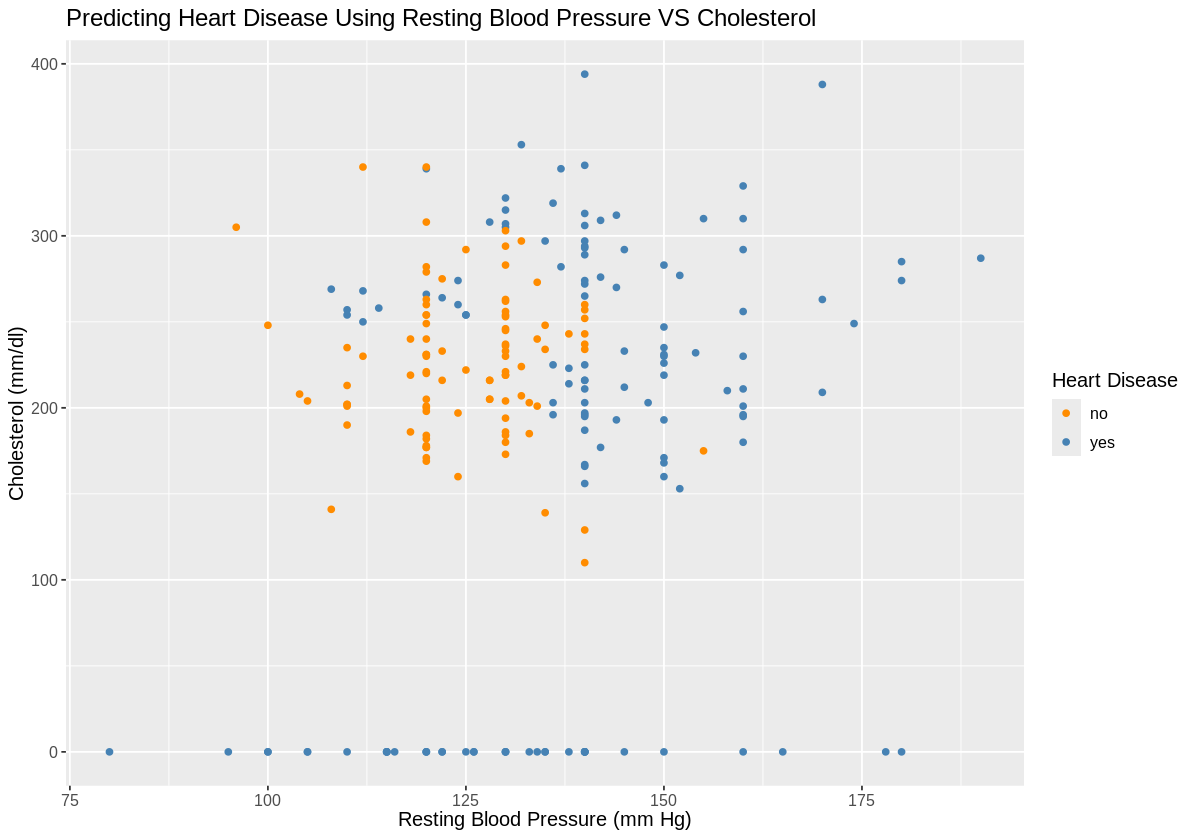

In [21]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_RestingBP_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = RestingBP_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_RestingBP_Cholesterol <- workflow() |>
        add_recipe(heart_recipe_RestingBP_Cholesterol) |>
        add_model(heart_spec_RestingBP_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_RestingBP_Cholesterol <- heart_fit_RestingBP_Cholesterol |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_RestingBP_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_RestingBP_Cholesterol,
             mapping = aes(x = RestingBP,
                           y = Cholesterol,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Resting Blood Pressure (mm Hg)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Predicting Heart Disease Using Resting Blood Pressure VS Cholesterol") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))
heart_plot_RestingBP_Cholesterol

In [22]:
# number of positive and negative observations
num_observations <- heart_train |>
    group_by(HeartDisease) |>
    summarize(num = n())

num_observations

HeartDisease,num
<fct>,<int>
no,307
yes,381


We see above that in the training set there are roughly an equal number of positive and negative test results, so we can go ahead with creating the model.

First we will create a workflow to find the best K value for the model. We will use cross-validation with 5 folds. We will also create a recipe to scale and center all the predictors to ensure all variables are weighted equally.

In [23]:
# classification for all predictors: picking the best k


# set the seed
set.seed(1234) 

# creating the recipe and model specifications
heart_recipe <- recipe(HeartDisease ~., data = heart_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


# vfold model
vfold <- vfold_cv(heart_train, v = 5, strata = HeartDisease)

# k testing values
k_vals <- tibble(neighbors = seq(from = 2, to = 50, by = 1))


#creating the workflow
results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_train) |>
    tune_grid(resamples = vfold, grid = k_vals) |>
    collect_metrics()
results

Warning message:
“tune samples were requested but there were 688 rows in the data. 683 will be used.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6452801,5,0.01373613,Preprocessor1_Model01
2,roc_auc,binary,0.6862203,5,0.02088406,Preprocessor1_Model01
3,accuracy,binary,0.6978029,5,0.02264468,Preprocessor1_Model02
3,roc_auc,binary,0.7183487,5,0.02088713,Preprocessor1_Model02
4,accuracy,binary,0.6978029,5,0.02264468,Preprocessor1_Model03
4,roc_auc,binary,0.7186835,5,0.02197869,Preprocessor1_Model03
5,accuracy,binary,0.6932869,5,0.01176970,Preprocessor1_Model04
5,roc_auc,binary,0.7254719,5,0.02179960,Preprocessor1_Model04
6,accuracy,binary,0.6932869,5,0.01176970,Preprocessor1_Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6452801,5,0.01373613,Preprocessor1_Model01
3,accuracy,binary,0.6978029,5,0.02264468,Preprocessor1_Model02
4,accuracy,binary,0.6978029,5,0.02264468,Preprocessor1_Model03
5,accuracy,binary,0.6932869,5,0.01176970,Preprocessor1_Model04
6,accuracy,binary,0.6932869,5,0.01176970,Preprocessor1_Model05
7,accuracy,binary,0.6817238,5,0.01386067,Preprocessor1_Model06
8,accuracy,binary,0.6817238,5,0.01386067,Preprocessor1_Model07
9,accuracy,binary,0.7108051,5,0.01492986,Preprocessor1_Model08
10,accuracy,binary,0.7108051,5,0.01492986,Preprocessor1_Model09


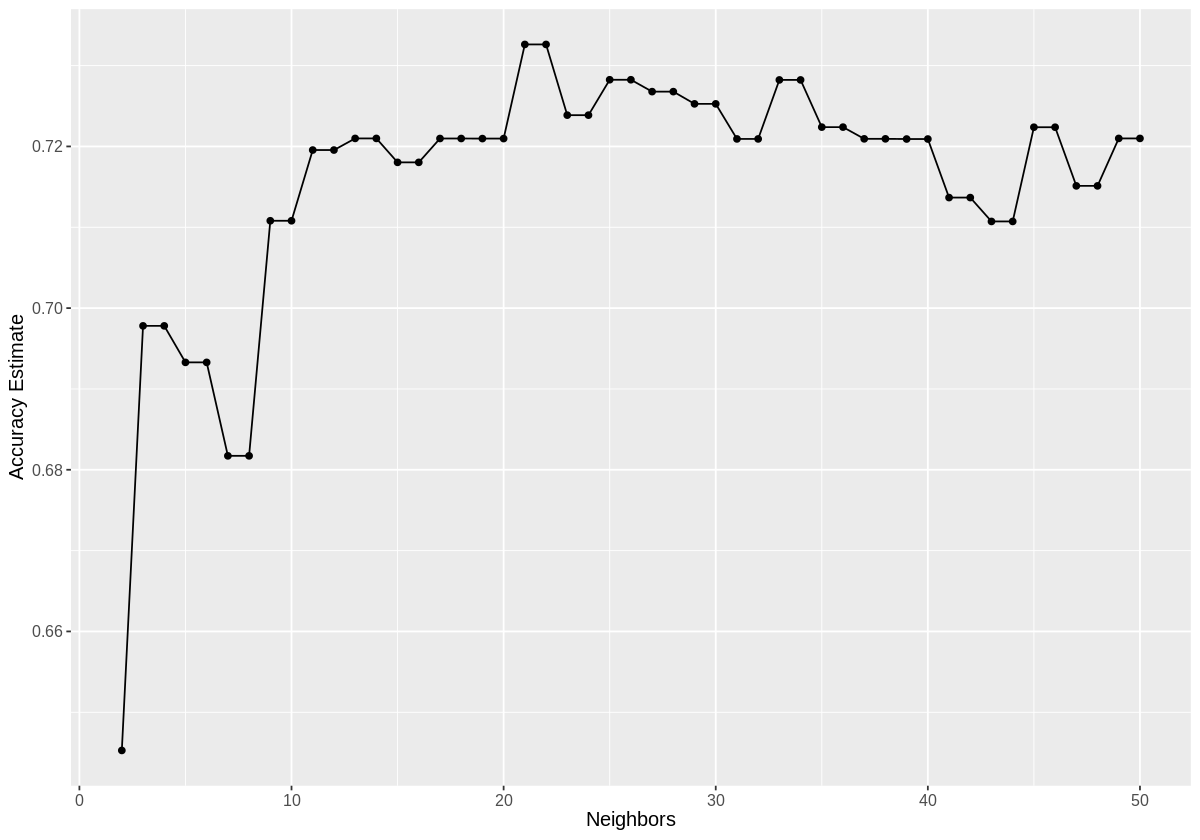

In [24]:
accuracies <- results |>
  filter(.metric == "accuracy")
accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

cross_val_plot

We can now pull the best K to find what will give us the greatest accuracy.

In [25]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 21

We know that the accuracy when using the training data is around 73% for K = 41. We know this is the greatest accuracy so we can now build our final model with K = 41.

In [26]:
# building the model

# set the seed
set.seed(1234) 
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(knn_spec) |>
       fit(data = heart_train)

heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(41,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2761628
Best kernel: rectangular
Best k: 41

## Results

We can now apply the final model to the testing set of data and see how it performs.

In [27]:
heart_test_predictions <- predict(heart_fit, heart_test) |>
       bind_cols(heart_test)
heart_test_predictions

.pred_class,Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
no,40,140,289,172,no
no,49,160,180,156,yes
yes,37,130,283,98,no
yes,48,138,214,108,yes
no,39,120,339,170,no
no,45,130,237,170,no
no,49,140,234,140,yes
no,43,120,201,165,no
yes,60,100,248,125,yes


In [28]:
# accuracy
heart_prediction_accuracy <- heart_test_predictions |>
         metrics(truth = HeartDisease, estimate = .pred_class)    
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7347826
kap,binary,0.4632336


In [36]:
# confusion matrix
heart_matrix <- heart_test_predictions |> 
       conf_mat(truth = HeartDisease, estimate = .pred_class)
heart_matrix

          Truth
Prediction no yes
       no  72  30
       yes 31  97

In [40]:
#calculates the accuracy of the model
accuracy <- (72+97)/(72+97+30+31)
accuracy

[1] 0.7347826

In [30]:
# performance metrics
heart_metrics <- metrics(heart_test_predictions, truth=HeartDisease, estimate=.pred_class) |>
    bind_rows(recall(heart_test_predictions, truth=HeartDisease, estimate=.pred_class)) |>
    bind_rows(precision(heart_test_predictions, truth=HeartDisease, estimate=.pred_class))

heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7347826
kap,binary,0.4632336
recall,binary,0.6990291
precision,binary,0.7058824


## Discussion:

### Summary

Through our methods, we have found that `Age` plays a significant role in heart disease patients, and as a person's age increases, they are more likely to develop heart disease. This can be seen in the graphs `heart_plot_Age_Cholesterol` and `heart_plot_Age_RestingBP`. In these graphs, `Age` is on the x-axis, and `Cholesterol` or `RestingBP` is on the y-axis. There is no correlation on the y-axis for both graphs. However, on the x-axis, as soon as the `Age` passes 50 years, heart disease begins to present. In `heart_plot_Age_MaxHR`, there appears to be a moderate negative correlation, meaning that as `Age` increases on the x-axis and `MaxHR` decreases on the y-axis, more cases of heart disease present themselves. In the first graph without age on the x-axis, `heart_plot_MaxHR_Cholesterol`, `MaxHR` is on the x-axis, and it is seen that once the heart rate passes ~130 beats per minute, heart disease becomes unlikely. Meanwhile, cholesterol still plays no role as there is no correlation. In the subsequent `heart_plot_RestingBP_MaxHR plot`, the previous idea that once the heart rate passes ~130 beats per minute, heart disease becomes unlikely, is supported. Also, `RestingBP` still plays no role. In the final graph, `heart_plot_RestingBP_Cholesterol`, there is no correlation that can be seen as there is a significant overlap of both points. These graphs make it clear that the only two factors that can be considered significant in predicting heart disease are `Age` and `MaxHR`.

Though our results we are able to see that our model is not entirely accurate and rather it has had 30 & 31 false negatives and false positives. Using the formula:

$${accuracy} = \frac{\mathrm{number \; of \; correct \; predictions}}{\mathrm{total \; number \; of \; predictions}} = \frac{72+97}{72+97+31+30} = 0.735.$$
it is seen that the accuracy of our model is 73.5% which is not great but better than others. However on the medical scence we would want our classification model to be stronger as an inaccuarcy of 26.5% is very significant. In practice this would mean that out of 100 people nearly 27 people would be misdiagnosed. To improve this we could train our model with more data, we could also have the model use cross validation. 

## References

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

World Health Organization. (2023). *Cardiovascular Diseases*. World Health Organization. https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1